# CIFAR-100 Convolutional Neural Network (CNN)
In this example we will go through the process of creating a convolutional neural network for the CIFAR-100 dataset. The CIFAR-100 dataset is a large dataset containing 100 classes which are grouped into 20 superclasses.

## Download the CIFAR-100 Dataset:
Let's begin by downloading the CIFAR-100 Dataset.
Follow the steps below:
- Go to __[this link](https://www.cs.toronto.edu/~kriz/cifar.html)__ and scroll down to the CIFAR-100 dataset section
- Click the link to download the CIFAR-100 python version
- Make a note of the location of this download or move it to a new location for later use
- Extract the compressed files from your .tar download

## Import the necessary libraries:

In [1]:
# used to install libraries if error with import
# substitute library name after --user argument and restart kernel after install

# import sys  
# !{sys.executable} -m pip install --user torchsummary scikit-image

In [2]:
# import libraries
from matplotlib import pyplot as plt
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from torchsummary import summary
from skimage.io import imsave, imread
from skimage import io,transform
import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(33)
import numpy as np

In [3]:
# view library versions
!pip3 list

Package                  Version
------------------------ ----------
anyio                    3.5.0
argon2-cffi              21.3.0
argon2-cffi-bindings     21.2.0
asttokens                2.0.5
attrs                    22.1.0
Babel                    2.11.0
backcall                 0.2.0
beautifulsoup4           4.12.0
bleach                   4.1.0
boltons                  23.0.0
brotlipy                 0.7.0
certifi                  2022.12.7
cffi                     1.15.1
charset-normalizer       2.0.4
cmake                    3.26.3
comm                     0.1.2
conda                    23.3.1
conda-content-trust      0.1.3
conda-package-handling   2.0.2
conda_package_streaming  0.7.0
contourpy                1.0.7
cryptography             38.0.4
cycler                   0.11.0
debugpy                  1.5.1
decorator                5.1.1
defusedxml               0.7.1
entrypoints              0.4
executing                0.8.3
fastjsonschema           2.16.2
filelock          

In [4]:
torch.cuda.is_available()

True

In [5]:
# make code device agnostic
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Reformat the extracted CIFAR-100 data:
Before we can begin building a dataclass or preview images we need to reformat the extracted files. The function below will help handle this.

In [6]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Now that the function is defined, create a variable containing the path to each file. 

In [7]:
train_dir = '/home/jcc/jupyter/GII/CIFAR_100_CNN/cifar-100-python/train'
print(f"train:\nBefore unpickle(): {type(train_dir)}") # look at the data type before using unpickle()
train = unpickle(train_dir) # reformat file and save as a new variable
print(f"After unpickle(): {type(train)}") # look at the data type after using unpickle()

test_dir = '/home/jcc/jupyter/GII/CIFAR_100_CNN/cifar-100-python/test'
test = unpickle(test_dir) # reformat test file
print(f"\ntest:\n{type(test)}")

meta_dir = '/home/jcc/jupyter/GII/CIFAR_100_CNN/cifar-100-python/meta'
meta = unpickle(meta_dir) # reformat meta file
print(f"\nmeta:\n{type(meta)}")

train:
Before unpickle(): <class 'str'>
After unpickle(): <class 'dict'>

test:
<class 'dict'>

meta:
<class 'dict'>


## Get more information about our new dictionaries:
Begin with the train_data dictionary.

In [8]:
print(train.keys()) # look at the contents of the dictionary

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])


In [9]:
for i in train: # print the data type of each key
    print(i, type(train[i]))

b'filenames' <class 'list'>
b'batch_label' <class 'bytes'>
b'fine_labels' <class 'list'>
b'coarse_labels' <class 'list'>
b'data' <class 'numpy.ndarray'>


In [10]:
# look at contents of each key
# print(f"File names: {set(train[b'filenames'])}") # uncomment to preview, very large print
print(f"Batch label: {set(train[b'batch_label'])}")
print(f"\nFine labels: {set(train[b'fine_labels'])}")
print(f"\nCoarse labels: {set(train[b'coarse_labels'])}")
print(f"\nData: {train[b'data']}")

Batch label: {32, 97, 98, 99, 102, 103, 104, 105, 110, 111, 49, 114, 116}

Fine labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}

Coarse labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

Data: [[255 255 255 ...  10  59  79]
 [255 253 253 ... 253 253 255]
 [250 248 247 ... 194 207 228]
 ...
 [248 240 236 ... 180 174 205]
 [156 151 151 ... 114 107 126]
 [ 31  30  31 ...  72  69  67]]


In [11]:
train[b'data'].shape # since this has the pixel data, check the shape

(50000, 3072)

In [12]:
train_data = train[b'data'] # save our image data into a new variable

### Summary of train dictionary:
- Fine label corresponds to the image class
- Coarse label corresponds to the image superclass
- Image data is stored in a numpy array of size (50000, 3072)

Now apply the same process to test.

In [13]:
print(f"{test.keys()}\n") # look at the contents of the dictionary

for i in test: # print the data type of each key
    print(i, type(test[i]))

# look at contents of each key
# print(f"\nFile names: {set(test[b'filenames'])}") # uncomment to preview, very large print
print(f"\nBatch label: {set(test[b'batch_label'])}")
print(f"\nFine labels: {set(test[b'fine_labels'])}")
print(f"\nCoarse labels: {set(test[b'coarse_labels'])}")
print(f"\nData: {test[b'data']}")
print(test[b'data'].shape)

test_data = test[b'data'] # save our image data into a new variable

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

b'filenames' <class 'list'>
b'batch_label' <class 'bytes'>
b'fine_labels' <class 'list'>
b'coarse_labels' <class 'list'>
b'data' <class 'numpy.ndarray'>

Batch label: {32, 97, 98, 99, 101, 102, 103, 104, 105, 110, 111, 49, 115, 116}

Fine labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}

Coarse labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

Data: [[199 196 195 ... 215 211 183]
 [113  88  72 ...  96  80  67]
 [ 61  61  67 ... 189 115  89]
 ...
 [ 24  24  22 ...  20  54  54]
 [ 86  93  28 ... 119 115 109]
 [246 240 214 ... 114 

### Summary of test dictionary:
- Fine label corresponds to the image class
- Coarse label corresponds to the image superclass
- Image data is stored in a numpy array of size (10000, 3072)

Finally, look at the meta dictionary.

In [14]:
print(f"{meta.keys()}\n") # look at the contents of the dictionary

for i in meta: # print the data type of each key
    print(i, type(meta[i]))
    
# look at key contents
print(f"\nFine label names: {set(meta[b'fine_label_names'])}")
print(f"\nCoarse label names: {set(meta[b'coarse_label_names'])}")
coarse = meta[b'coarse_label_names'] # create variable to store for later use
fine = meta[b'fine_label_names'] # create variable to store for later use

dict_keys([b'fine_label_names', b'coarse_label_names'])

b'fine_label_names' <class 'list'>
b'coarse_label_names' <class 'list'>

Fine label names: {b'forest', b'dinosaur', b'man', b'plate', b'lizard', b'squirrel', b'castle', b'wardrobe', b'beaver', b'cloud', b'bus', b'possum', b'rose', b'flatfish', b'clock', b'pear', b'lawn_mower', b'motorcycle', b'poppy', b'chair', b'chimpanzee', b'snail', b'streetcar', b'girl', b'sea', b'boy', b'bottle', b'can', b'road', b'tulip', b'tank', b'train', b'bicycle', b'tiger', b'sunflower', b'otter', b'worm', b'tractor', b'dolphin', b'wolf', b'orange', b'spider', b'telephone', b'bowl', b'cockroach', b'caterpillar', b'camel', b'cup', b'hamster', b'television', b'mountain', b'elephant', b'oak_tree', b'beetle', b'lion', b'skunk', b'pine_tree', b'mushroom', b'aquarium_fish', b'crocodile', b'maple_tree', b'palm_tree', b'porcupine', b'turtle', b'woman', b'rocket', b'cattle', b'bed', b'raccoon', b'bee', b'pickup_truck', b'apple', b'table', b'butterfly', b'leopar

### Summary of meta dictionary:
- Contains the name corresponding to each class and superclass

## Preview an image:
Per the documentation for the CIFAR-100 dataset:
- Each row of the array stores a 32x32 color image
- The first 1024 entries contain the red channel values
- The next 1024 entries contain the green channel values
- The final 1024 entries contain the blue channel values
- The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the first image

Recall that a 32x32 RGB image takes the shape (32,32,3)

<class 'numpy.ndarray'>
Before reshape: (3072,)
After reshape and transpose: (32, 32, 3)
b'large_omnivores_and_herbivores'
 b'cattle'


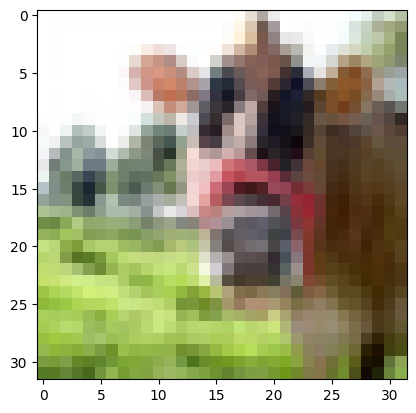

In [15]:
# read the first image from our train data set
train_img = train_data[0] # the image is the first row
print(type(train_img)) # look at data type
print(f"Before reshape: {train_img.shape}") # print initial shape
train_img = train_img.reshape(3,32,32) # reshape the image to display
train_img = train_img.transpose(1,2,0) # transpose the image to display
print(f"After reshape and transpose: {train_img.shape}") # print shape after transformation
train_img = train_img[:,:,:]
plt.imshow(train_img) # display image
print(f"{coarse[train[b'coarse_labels'][0]]}\n {fine[train[b'fine_labels'][0]]}") # display image labels

## Preview more images with their labels:
Create arrays to store 16 images from the train_data array and the respective labels.

In [16]:
cl = [] # array to store coarse labels
fl = [] # array to store fine labels
imgs = [] # array to store image data
for i in range(1,17):
    fl.append(train[b'fine_labels'][i]) # add value for fine label to fl array
    cl.append(train[b'coarse_labels'][i]) # add value for coarse label to cl array
    x = train_data[i] # load the image from train_data array
    x = x.reshape(3,32,32) # transform the image to be displayed
    x = x.transpose(1,2,0)
    imgs.append(x)

img1 shape: (32, 32, 3)

b'vehicles_1'
 b'bicycle'


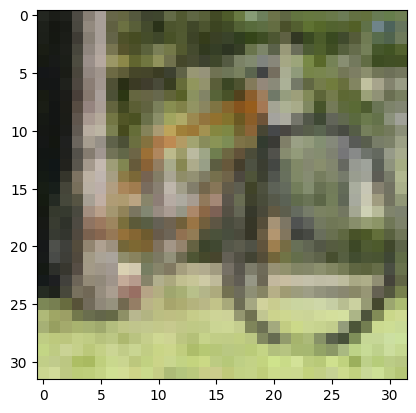

In [17]:
# Look at the shape and display img15
print(f"img1 shape: {imgs[15].shape}\n") # confirm shape of image
plt.imshow(imgs[15]) # display image
print(f"{coarse[cl[15]]}\n {fine[fl[15]]}") # display image labels

### Create the plot for the images and their labels:
Use the arrays created above to define a plot and view multiple images and their labels at the same time.

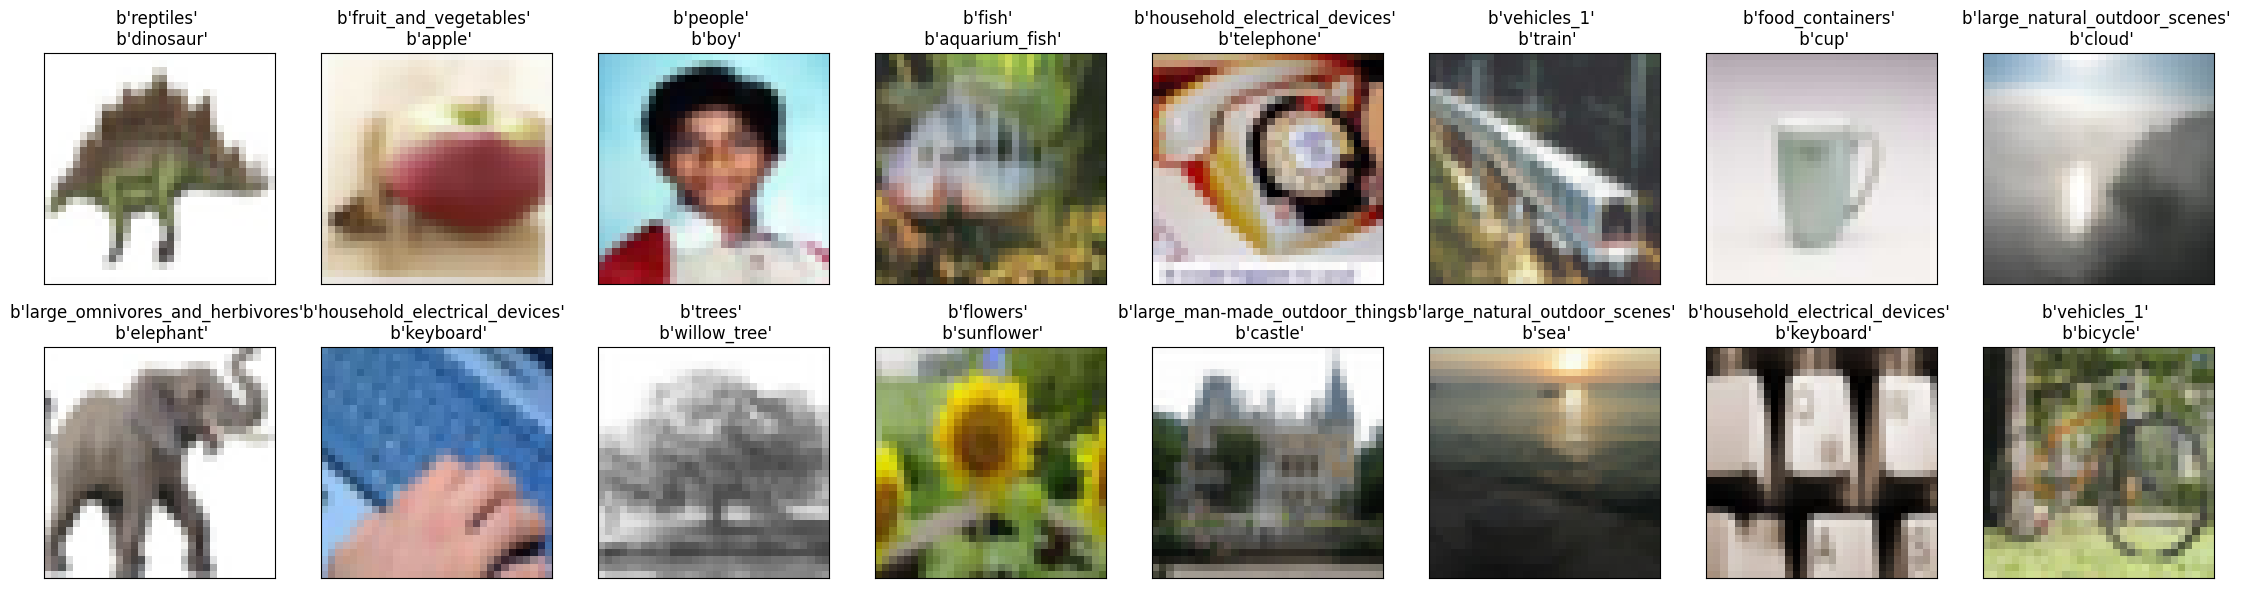

In [18]:
# 2x8 display
rows, columns = 2,8 # create variables to edit subplot shape
plot = plt.figure(figsize=(28, 7)) # create plot and adjust size (x,y)
for i in range(1, columns*rows+1): # range needs to start at 1
    plot.add_subplot(rows, columns, i) # add image i to subplot 
    plt.imshow(imgs[i-1])
    plt.xticks([]), plt.yticks([]) # turn off ticks on x and y axis (30 pixels x 30)
    plt.title("{} \n {}" # add coarse and fine label above image
          .format(meta[b'coarse_label_names'][cl[i-1]], meta[b'fine_label_names'][fl[i-1]]))
plt.show() # display plot

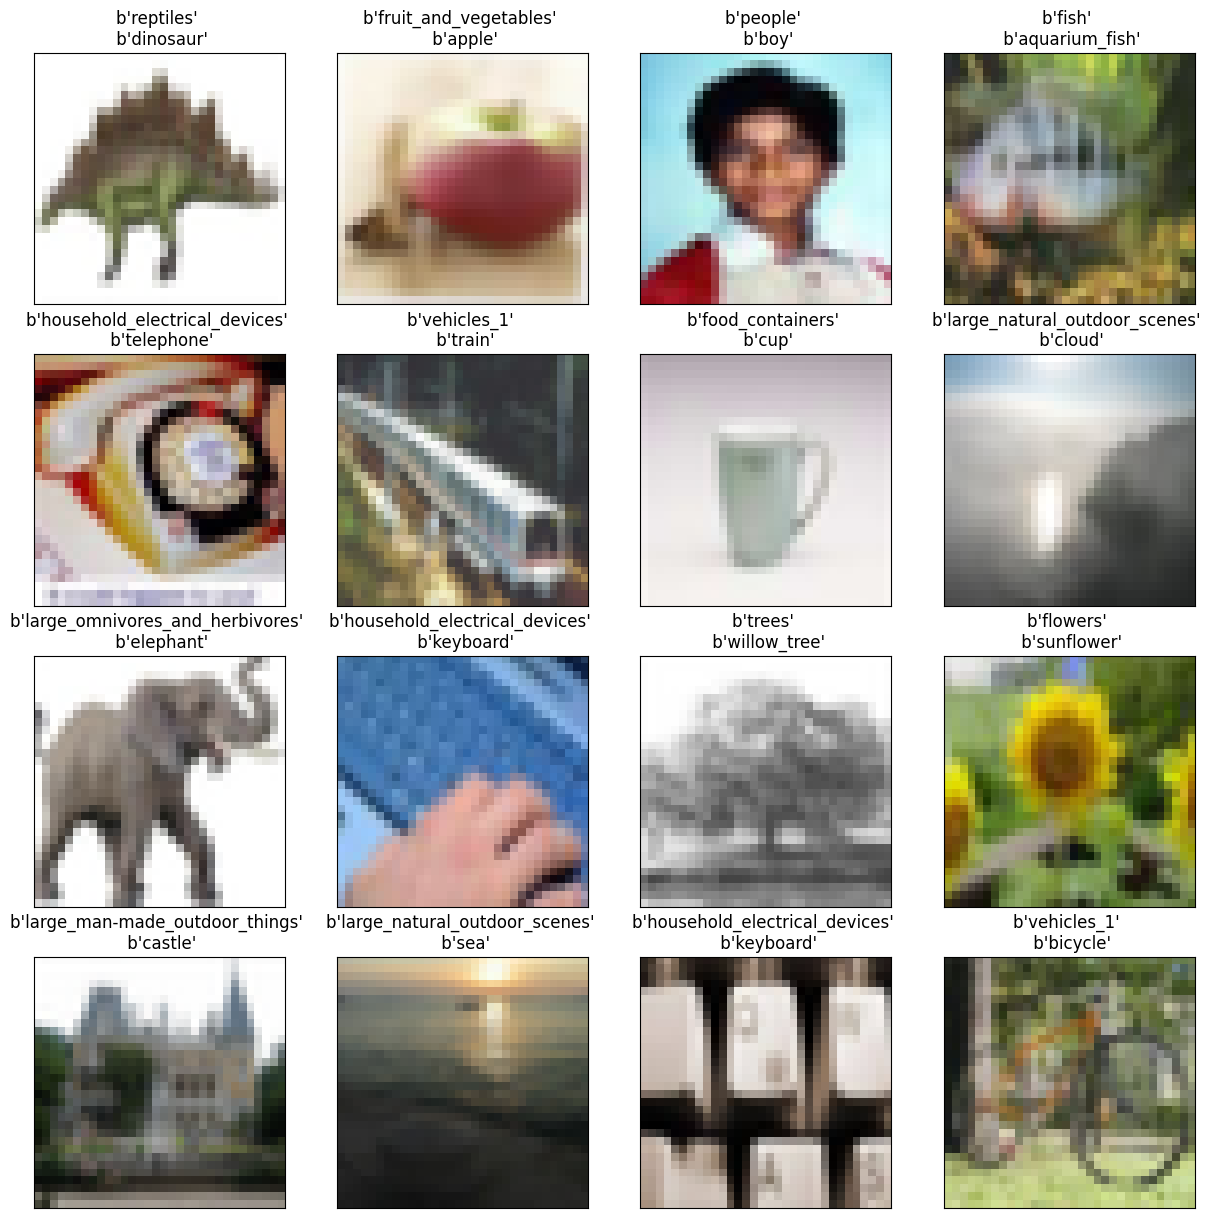

In [19]:
# 4x4 display
rows, columns = 4,4 # create variables to edit subplot shape
plot = plt.figure(figsize=(15, 15)) # create plot and adjust size (x,y)
for i in range(1, columns*rows+1): # range needs to start at 1
    plot.add_subplot(rows, columns, i) # add image i to subplot 
    plt.imshow(imgs[i-1])
    plt.xticks([]), plt.yticks([]) # turn off ticks on x and y axis (30 pixels x 30)
    plt.title("{} \n {}" # add coarse and fine label above image
          .format(meta[b'coarse_label_names'][cl[i-1]], meta[b'fine_label_names'][fl[i-1]]))
plt.show() # display plot

## Create a dataset class:
This class will make it quick and easy to format all of the images for the model.

In [20]:
class ImageData(Dataset):
    def __init__(self,datavar,flabeldict):
        super().__init__()
        self.image = datavar
        # self.clabel = clabeldict
        self.flabel = flabeldict
        
    def __len__(self): # function to determine number of images in dataset
        return(len(self.image))
    
    def __getitem__(self,idx): # retrieve image and corresponding labels
        
        # 3 channels
        img = self.image[idx] # img stores row 'idx' from image array datavar
        img = img.reshape(3,32,32) # transform image
        img = img.transpose(1,2,0)
        img = img.reshape(3,32,32) # reshape for CNN
        
        img = img/255 # normalize the image data
        
        flabel = self.flabel[idx]
        
        return torch.from_numpy(img).float(),torch.tensor(flabel).float()

### Create datasets using the dataset class:
Recall the class takes inputs in the order of imagedata, coarse label dictionary, fine label dictionary.

In [22]:
image_set_train = ImageData(train_data,train[b'fine_labels'])
image_set_test = ImageData(test_data,test[b'fine_labels'])

### Test the getitem function:
- Test by loading the 0th row from train_data and the respective labels
- Verify by plotting the image and labels
- Recall from earlier train_data[0] corresponds to b'large_omnivores_and_herbivores' and b'cattle'

Fine label: (tensor(19.), torch.Size([]))     
Image data: tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9255, 0.9216, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.7137, 0.7608, 0.6549],
         ...,
         [0.0980, 0.1451, 0.1294,  ..., 0.1961, 0.1608, 0.1412],
         [0.9647, 0.9725, 0.9725,  ..., 0.6039, 0.4510, 0.5255],
         [0.4863, 0.4235, 0.4902,  ..., 0.0588, 0.1059, 0.0706]],

        [[0.0588, 0.0941, 0.1059,  ..., 0.3098, 0.2392, 0.2039],
         [0.9686, 0.9882, 0.9843,  ..., 0.4392, 0.3569, 0.4000],
         [0.3608, 0.2706, 0.3333,  ..., 0.1059, 0.1412, 0.0824],
         ...,
         [0.3255, 0.6510, 0.7216,  ..., 0.2706, 0.2784, 0.3490],
         [0.3686, 0.4078, 0.5451,  ..., 0.3451, 0.2627, 0.1176],
         [0.7216, 0.8392, 0.4314,  ..., 0.5020, 0.7569, 0.8392]],

        [[0.4902, 0.7804, 0.8588,  ..., 0.1647, 0.1922, 0.2824],
         [0.3137, 0.3529, 0.5333,  ..., 0.3451, 0.2471, 0.1176],

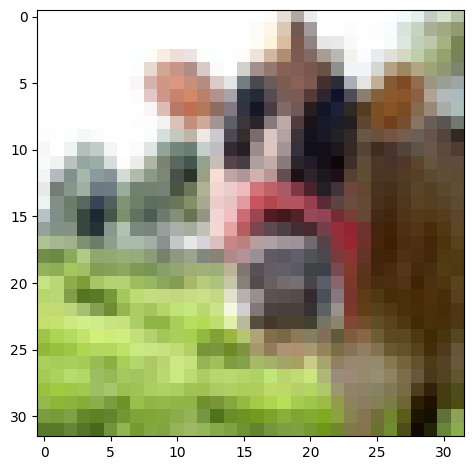

In [24]:
print(f"Fine label: {image_set_train.__getitem__(0)[1], image_set_train.__getitem__(0)[1].shape} \
    \nImage data: {image_set_train.__getitem__(0)[0]}")

# plot the image to verify
img0 = image_set_train.__getitem__(0)[0] # get item (0) and image [0] and see shape
print(f"\nImage shape after __getitem__ function: {img0.shape}")

img0 = img0.numpy().squeeze() # squeeze to format for image display
print(f"Image shape after squeeze: {img0.shape}")

# 3 channels
img0 = img0.reshape(32,32,3)

print(f"Image shape after reshape: {img0.shape}")
flab = image_set_train.__getitem__(0)[1]
flab = flab.numpy().squeeze().astype(int)

print(f"\n Fine label: {meta[b'fine_label_names'][flab]}")

io.imshow(img0.squeeze()) # display image
plt.show()

## Dataloaders:
Now that we've confirmed our dataset class and getitem function work as intended, use the imported DataLoader function to create batches for the model.

The function uses the arguments:
- 0: data set created from class
- batch_size: the number of items in each batch
- shuffle: randomize the items of each batch, this is especially important to prevent bias when the data set is very ordered

In [25]:
train_loader = DataLoader(image_set_train,batch_size=25,shuffle=True)
test_loader = DataLoader(image_set_test,batch_size=25,shuffle=True)
input,ftarget = next(iter(train_loader)) # create variables to store image input, and coarse/fine label targets
print(input.shape,ftarget.shape) # check shapes

torch.Size([25, 3, 32, 32]) torch.Size([25])


## Build the model:
Create a class for the CNN model.
- Define layers (convolutional, batch normalization, dropout, fully connected, etc.)
  - A smaller kernel will compute faster and result in a less complex model
  - Convolutional layers apply different kernels over the image to generate features
  - Batch normalization is used to help normalize data after convolution
  - Dropout layers use a probability to mute connections and prevent overfitting or association between connections
  - The fully connected layers are used to extract more data and classify
- Input layer needs to correspond to batch size, channels, etc.
- Output layer for each label
- Define feed-forward function and return outputs
- $$
FeatureSize = \frac{\left ( ImageSize + \left (2*PaddingSize  \right ) - KernelSize \right )}{Stride} + 1
$$

In [50]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # 3 channels input layer
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1) # use Conv2d for images
        self.BN1 = nn.BatchNorm2d(32) # input corresponds to most recent out_channels
        
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.BN2 = nn.BatchNorm2d(64)
        # maxpool --> HxW or [B,1,H,W]
        self.drop1 = nn.Dropout2d(p=0.2) # dropout layer for 2d convolution
        
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.BN3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.BN4 = nn.BatchNorm2d(256)
        # maxpool --> HxW
        self.drop2 = nn.Dropout2d(p=0.2)
        
        self.conv5 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.BN5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1)
        self.BN6 = nn.BatchNorm2d(512)
        # maxpool
        self.drop3 = nn.Dropout2d(p=0.2)
        
        
        self.dropFC1 = nn.Dropout(p=0.6) # dropout for fully connected layer
        self.fc1 = nn.Linear(8*8*256,1000) # fully connected layer 1 to feed output of convolutional layers
        self.dropFC2 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(1000,500) # this fc layer feeds into output layers
        self.fc3 = nn.Linear(500,100) # output for second label
        
    def forward(self,x): # pass forward function
        
        # conv & relu, batch normalization, pooling, dropout
        x = self.conv1(x) # send through 1st convolutional layer
        x = F.relu(x) # apply Relu activation function
        x = self.BN1(x) # batch norm
        x = self.conv2(x)
        x = F.relu(x)
        x = self.BN2(x)
        x = F.max_pool2d(x,2) # max pool with 2x2 kernel; feature size becomes 16x16
        x = self.drop1(x) # 2d conv dropout
        
        x = F.relu(self.conv3(x)) # you can combine feed forward processes like this by nesting arguments
        x = self.BN3(x)
        x = F.relu(self.conv4(x))
        x = self.BN4(x)
        x = F.max_pool2d(x,2) # 8x8
        x = self.drop2(x)
        
        # x = F.relu(self.conv5(x))
        # x = self.BN5(x)
        # x = F.relu(self.conv6(x))
        # x = self.BN6(x)
        # x = self.drop3(x)
        # x = F.max_pool2d(x,2) # 4x4
        
        x = x.view(-1,8*8*256) # format for fully connected layers
        
        x = self.dropFC1(x)
        x = F.relu(self.fc1(x)) # send through first fully connected layer and apply Relu
        x = self.dropFC2(x)
        x = self.fc2(x)
        
        f_label = self.fc3(x) # output layer for fine label
        
        return f_label

### Create the model and view summary of input with proper shape.

In [61]:
model = Net().to(device) # initialize variable with Net class

# 3 channels
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 64, 32, 32]          18,496
       BatchNorm2d-4           [-1, 64, 32, 32]             128
         Dropout2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 256, 16, 16]         295,168
       BatchNorm2d-9          [-1, 256, 16, 16]             512
        Dropout2d-10            [-1, 256, 8, 8]               0
          Dropout-11                [-1, 16384]               0
           Linear-12                 [-1, 1000]      16,385,000
          Dropout-13                 [-1, 1000]               0
           Linear-14                  [

### Define the parameters of the model.

In [63]:
# model parameters
lr = 0.0001 # learning rate
n_epochs = 20 # number of epochs to train/test
loss_fn = nn.CrossEntropyLoss() # loss function
log_interval = 200 # interval used to print updates in train/test
optimizer = optim.Adam(model.parameters(),lr=lr) # optimizer for model

# arrays to characterize performance
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(image_set_train) for i in range(n_epochs+1)]

## Create functions for the training and testing loops:

In [64]:
# training function
def train(epoch):
    model.train() # put the model in training mode
    for batch_idx, (data, ftarget) in enumerate(train_loader): # main loop; iterate through train_loader
        data,ftarget = data.float(),ftarget.long() # create variables for model data and outputs
        optimizer.zero_grad() # zero the gradient
        out = model(data.to(device)) # store model output into variables
        
        out = torch.squeeze(out) # model output for coarse label
        ftarget = torch.squeeze(ftarget) # coarse label targets from dataloaders and dataclass

        # print(f"\nOutput shape: {out.shape}\nF_Target shape: {ftarget.shape}")
        # print(f"\n\nOutput: {out}\n\nF_Target: {ftarget}")
        
        loss = loss_fn(out.to(device),ftarget.to(device))
        loss.backward() # calculate gradients
        optimizer.step() # update model
        
        # print out information about the progress and update output arrays for training
        if batch_idx % log_interval == 0: # periodicity using interval previously defined
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(image_set_train),
                100. * batch_idx* len(data) / len(image_set_train), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(image_set_train)))
            torch.save(model.state_dict(), 'model.pth') # save the model and optimizer states in files
            torch.save(optimizer.state_dict(), 'results.pth')

In [65]:
# testing function
def test():
    model.eval() # place model in testing mode
    print("Testing...")
    test_loss = 0
    f_correct = 0 # number of fine labels correct
    with torch.no_grad():
        for data, ftarget in test_loader:
            data,ftarget = data.float(),ftarget.long() # format for loss
            out = model(data.to(device)) # store output from model in variable
            out = torch.squeeze(out)
            
            #print(ftarget)
            ftarget = torch.squeeze(ftarget)
            # print(f"out: {out.shape}\nftarget: {ftarget.shape}")
            
            loss = loss_fn(out.to(device),ftarget.to(device))
            test_loss += loss.item() # add loss value to evaluate model

            fpred = out.data.max(1, keepdim=True)[1]
            f_correct += fpred.eq(ftarget.data.view_as(fpred).to(device)).sum() # if fpred matches label add tally
    test_loss /= len(test_loader) # calculate test loss
    test_losses.append(test_loss) # add test loss to array
    
    print('\nTest set: Avg. loss: {:.4f}, Fine Accuracy: {}/{} ({:.0f}%)\n'.format( # print output about testing
        test_loss,
        f_correct, len(image_set_test), 100. * f_correct / len(image_set_test)))

In [66]:
# libraries for analysis of training/testing
import time
from datetime import timedelta

start_time = time.time() # initialize start time

# Perform lots of computations.

test() # run initial test of model before training
for epoch in range(1, n_epochs + 1): # run training epochs and test at end of each training period
    train(epoch) # train model for each epoch
    test() # test model again after each train
    
elapsed_time_secs = time.time() - start_time # caluclate total time for training/testing

msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs)) # output message

print(msg)

Testing...

Test set: Avg. loss: 4.6056, Fine Accuracy: 100/10000 (1%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 4.735166
Train Epoch: 1 [5000/50000 (10%)]	Loss: 4.318340
Train Epoch: 1 [10000/50000 (20%)]	Loss: 4.095408
Train Epoch: 1 [15000/50000 (30%)]	Loss: 4.028790
Train Epoch: 1 [20000/50000 (40%)]	Loss: 4.144658
Train Epoch: 1 [25000/50000 (50%)]	Loss: 3.957054
Train Epoch: 1 [30000/50000 (60%)]	Loss: 3.521869
Train Epoch: 1 [35000/50000 (70%)]	Loss: 3.971156
Train Epoch: 1 [40000/50000 (80%)]	Loss: 4.185592
Train Epoch: 1 [45000/50000 (90%)]	Loss: 3.163692
Testing...

Test set: Avg. loss: 3.5347, Fine Accuracy: 1701/10000 (17%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 4.019452
Train Epoch: 2 [5000/50000 (10%)]	Loss: 3.664111
Train Epoch: 2 [10000/50000 (20%)]	Loss: 3.982708
Train Epoch: 2 [15000/50000 (30%)]	Loss: 4.062902
Train Epoch: 2 [20000/50000 (40%)]	Loss: 3.817948
Train Epoch: 2 [25000/50000 (50%)]	Loss: 3.801512
Train Epoch: 2 [30000/50000 (60%)]	Loss: 3.686093
Train Epoch: 2 [

## Observe the performance of the model:

Now that the model has finished testing and training we are able to plot the respective losses.

In [67]:
len(test_counter), print(test_counter)

[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000, 1000000]


(21, None)

In [68]:
len(test_losses), print(test_losses)

[4.6056025385856625, 3.5346539503335954, 3.283564649820328, 3.1360290449857713, 3.0544938588142396, 2.9900377345085145, 2.950074774026871, 2.917832052707672, 2.891280072629452, 2.908540040850639, 2.8871669963002207, 2.898289979696274, 2.9253833517432213, 2.9179019191861153, 2.9653734195232393, 2.9723742040991783, 3.011483133435249, 3.027705963850021, 3.087366747558117, 3.139757069349289, 3.16734681814909]


(21, None)

Text(0, 0.5, 'loss value')

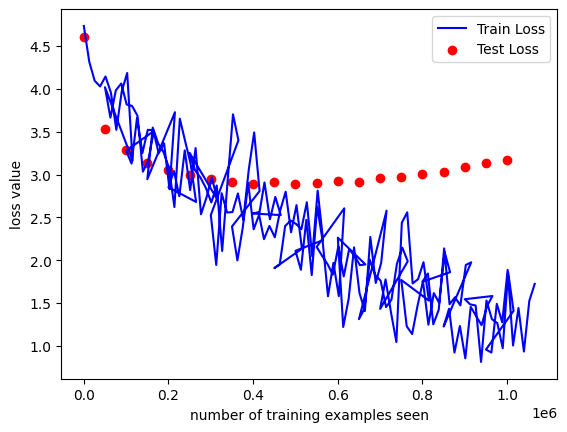

In [69]:
fig = plt.figure() # create a plot
plt.plot(train_counter,train_losses,color='blue') # define the characteristics of the train plot
plt.scatter(test_counter,test_losses,color='red') # define the characteristics of teh test plot
plt.legend(['Train Loss','Test Loss'],loc='upper right') # create a legend and define location
plt.xlabel('number of training examples seen') # label for x axis
plt.ylabel('loss value') # label for y axis

### Conclusions:

- From the plot we see the shape of the test loss looks appropriate
  - The value looks like it saturates around 2.8, likely due to the model
  - The gradual increase of the loss toward the end is chacteristic of overfitting
- The training loss looks sporadic but decreases in an expected manner
  - This is likely due to a number of factors such as the model, lr, etc

## Test the model with sample images form the internet:

- Let's test the model we made with some images from the web
- Add some images to the directory containing your .ipynb file and saved models
- Below we will look at the labels and create a function to classify untrained images

In [70]:
print(f"Coarse Labels:\n{coarse}\n\nFine Labels:\n{fine}")

Coarse Labels:
[b'aquatic_mammals', b'fish', b'flowers', b'food_containers', b'fruit_and_vegetables', b'household_electrical_devices', b'household_furniture', b'insects', b'large_carnivores', b'large_man-made_outdoor_things', b'large_natural_outdoor_scenes', b'large_omnivores_and_herbivores', b'medium_mammals', b'non-insect_invertebrates', b'people', b'reptiles', b'small_mammals', b'trees', b'vehicles_1', b'vehicles_2']

Fine Labels:
[b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver', b'bed', b'bee', b'beetle', b'bicycle', b'bottle', b'bowl', b'boy', b'bridge', b'bus', b'butterfly', b'camel', b'can', b'castle', b'caterpillar', b'cattle', b'chair', b'chimpanzee', b'clock', b'cloud', b'cockroach', b'couch', b'crab', b'crocodile', b'cup', b'dinosaur', b'dolphin', b'elephant', b'flatfish', b'forest', b'fox', b'girl', b'hamster', b'house', b'kangaroo', b'keyboard', b'lamp', b'lawn_mower', b'leopard', b'lion', b'lizard', b'lobster', b'man', b'maple_tree', b'motorcycle', b'mountain', b'

In [71]:
# images for this function should only have 3 channels
def classify(model,image,f_classes):
    
    image = transform.resize(image,(32,32))
    io.imshow(image)
    plt.show()
    
    model = model.eval()
    image = torch.from_numpy(image)
    image = image.float()
    image = image.reshape(3,32,32)
    image = image.unsqueeze(0)
    print(image.shape)
    
    output = model(image.to(device))
    # print(f"Predictions: \n{output}\n")
    _,fpredicted = torch.max(output.data,1)
    print(f"Predicted Fine: {f_classes[fpredicted]}\n")

In [72]:
# read and normalize .png files
lobster = io.imread('lobster.png') / 255
rabbit = io.imread('rabbit.png') / 255
lobster = lobster[:,:,:3] # get rid of alpha channel for .png file
rabbit = rabbit[:,:,:3]

# read and normalize .jpg files
apple = io.imread('apple.jpg') / 255
baby = io.imread('baby.jpg') / 255
bike = io.imread('bike.jpg') / 255
cow = io.imread('cow.jpg') / 255
dolphin = io.imread('dolphin.jpg') / 255
seal = io.imread('seal.jpg') / 255

<function matplotlib.pyplot.show(close=None, block=None)>

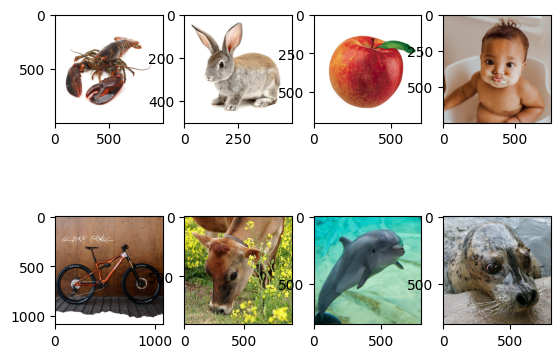

In [73]:
# store images into an array
new_pics = [lobster,rabbit,apple,baby,bike,cow,dolphin,seal]

# plot the images to make sure they look alright before classify function and transformations
f, ax = plt.subplots(2,4)
ax[0,0].imshow(lobster)
ax[0,1].imshow(rabbit)
ax[0,2].imshow(apple)
ax[0,3].imshow(baby)
ax[1,0].imshow(bike)
ax[1,1].imshow(cow)
ax[1,2].imshow(dolphin)
ax[1,3].imshow(seal)
plt.show

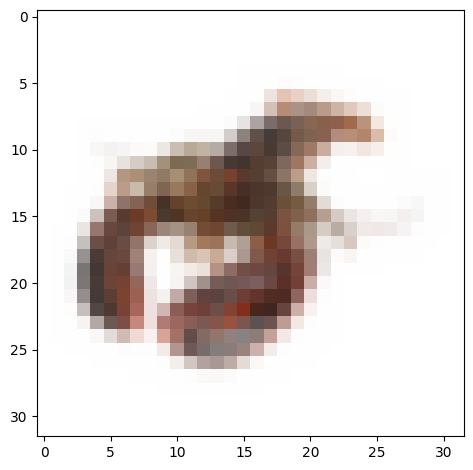

torch.Size([1, 3, 32, 32])
Predicted Fine: b'dinosaur'



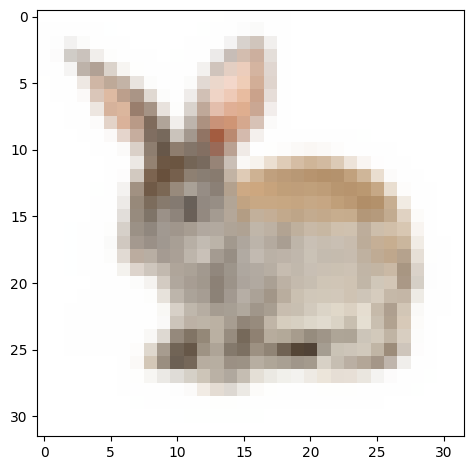

torch.Size([1, 3, 32, 32])
Predicted Fine: b'dinosaur'



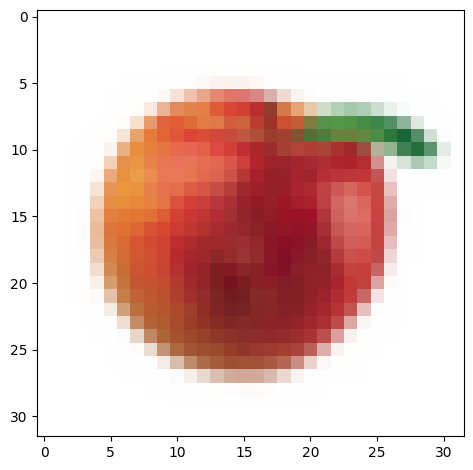

torch.Size([1, 3, 32, 32])
Predicted Fine: b'apple'



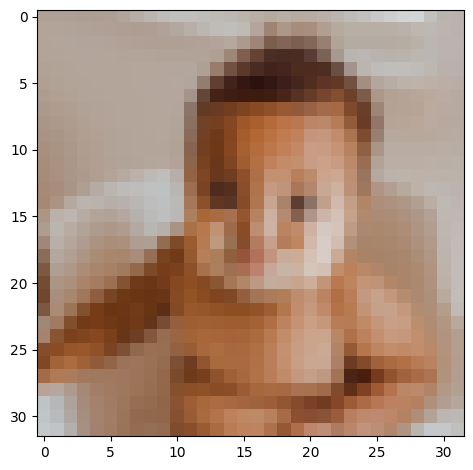

torch.Size([1, 3, 32, 32])
Predicted Fine: b'woman'



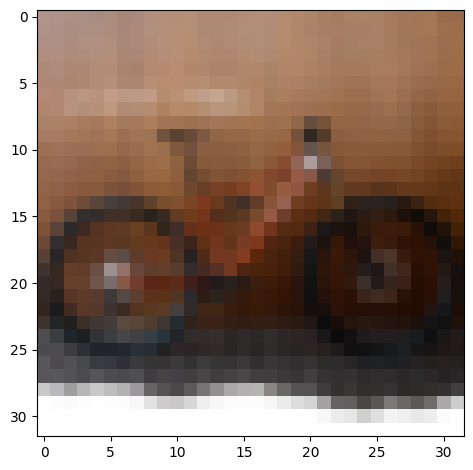

torch.Size([1, 3, 32, 32])
Predicted Fine: b'sea'



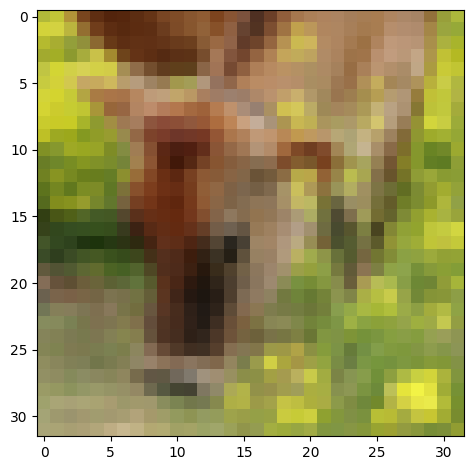

torch.Size([1, 3, 32, 32])
Predicted Fine: b'cattle'



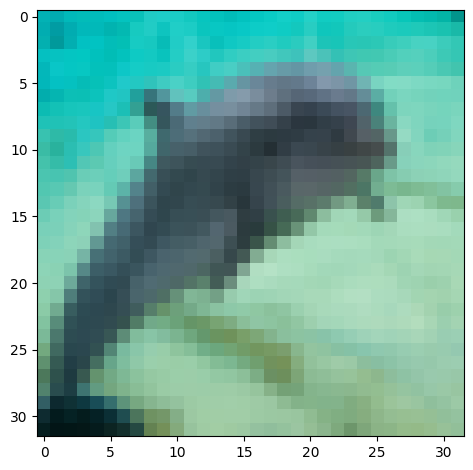

torch.Size([1, 3, 32, 32])
Predicted Fine: b'oak_tree'



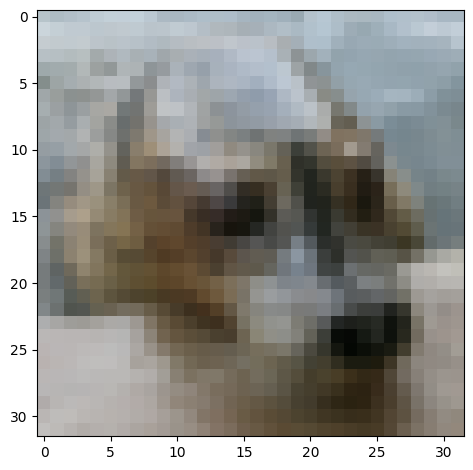

torch.Size([1, 3, 32, 32])
Predicted Fine: b'bus'



In [74]:
# iterate through untrained images and classify
for i in new_pics:
    classify(model,i,fine)

## Summary:

- In this demo we covered the general process of loading a dataset and creating a CNN for image classification.
- The images tested did not perform very well as expected, the final fine label prediction accuracy was 31%
- 2/8 were correctly predicted while others were off
- The model needs to be refined to improve performance, or try a different approach such as a transfer model.